# Import stuff of D7RGESolver and $\nu \text{DoBe}$

In [1]:
import sys
import os
sys.path.append("..")  
from RGE_dim7 import solve_rge
nudobe_path = os.path.join("..", "external_tools", "nudobe", "src")
sys.path.append(nudobe_path)
sys.path.append(os.path.join("..", "external_tools", "nudobe"))  
import nudobe
from EFT import SMEFT
from constants import *
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, lambdify, simplify
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from ovbb import extract_0vbb_operators_downbasis, half_life_136Xe
%matplotlib inline

#### In this notebook, we plot the 2D constrains on $C_{SMEFT}^{(7)}-m_{\beta\beta}$ with or without RG running effect
#### We will use the function half_life_136Xe to draw the plot of constrains on $m_{\beta\beta}-C_7^i$
#### function half_life_136Xe are analytical expression for half-life of $0\nu\beta\beta$, which are output by $\nu\text{DoBe}$
#### For $\Lambda=80$ GeV, there is no SMEFT RG running 
#### For $\Lambda>80$ GeV, we have to consider the SMEFT RG running

### Use the $\nu \text{DoBe}$ command to generate analytical expression of half-life

In [2]:
C_in={"LH(7)":1e-20,"LLQuH(7)":1e-16}
model = SMEFT(C_in)
print(model.generate_formula("136Xe"))


$T_{1/2}^{-1} = +1.59~\mathrm{y}^{-1}\times 10^{13}\left|C_{LH}^{(7)}~\mathrm{GeV}^3\right|^2+3.61~\mathrm{y}^{-1}\times 10^{6}\left|C_{LLQuH}^{(7)}~\mathrm{GeV}^3\right|^2-1.52~\mathrm{y}^{-1}\times 10^{10} \mathrm{Re}\left[C_{LH}^{(7)}~\mathrm{GeV}^3({C_{LLQuH}^{(7)}})^*\right]$


#### We have involved the analytical expression for half-life of $0\nu\beta\beta$ as a function of all WCs of dim-7 SMEFT operators in function half_life_136Xe, defined in ovbb.py. In the following, we will use these this functions to calculate the $T_{1/2}^{0\nu}$ fastly

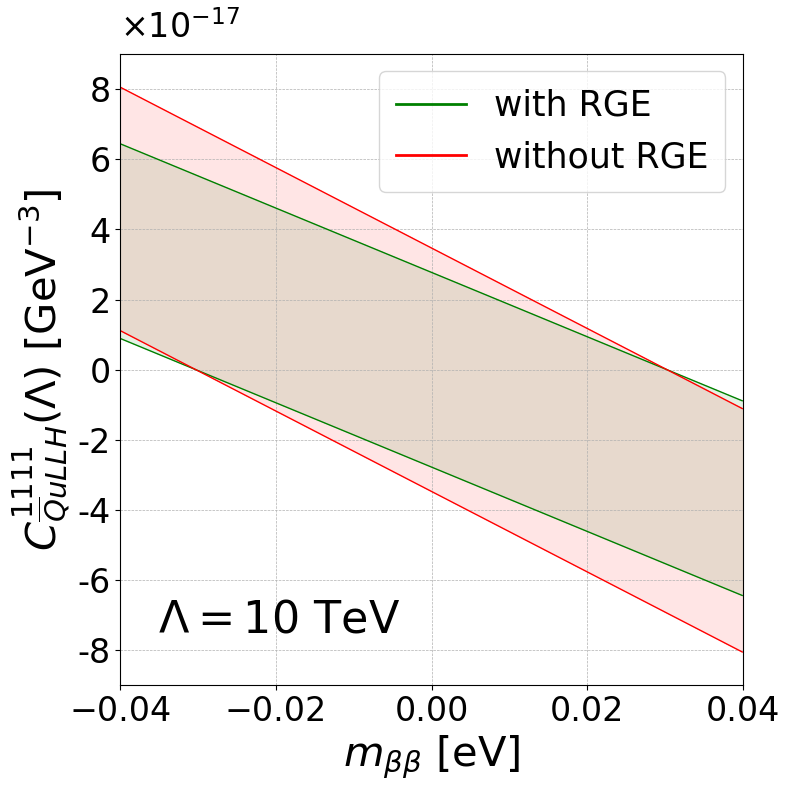

In [3]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"QuLLH_1111": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-9e-17, 9e-17, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.1)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)


legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='with RGE'),
        Line2D([0], [0], color='red', lw=2, linestyle='-', label='without RGE')
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{\overline{Q}uLLH}^{1111}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e17))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-17}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.text(0.45, 0.07, r'$\Lambda = 10$ TeV', transform=ax.transAxes, fontsize=32, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_QuLLH.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()

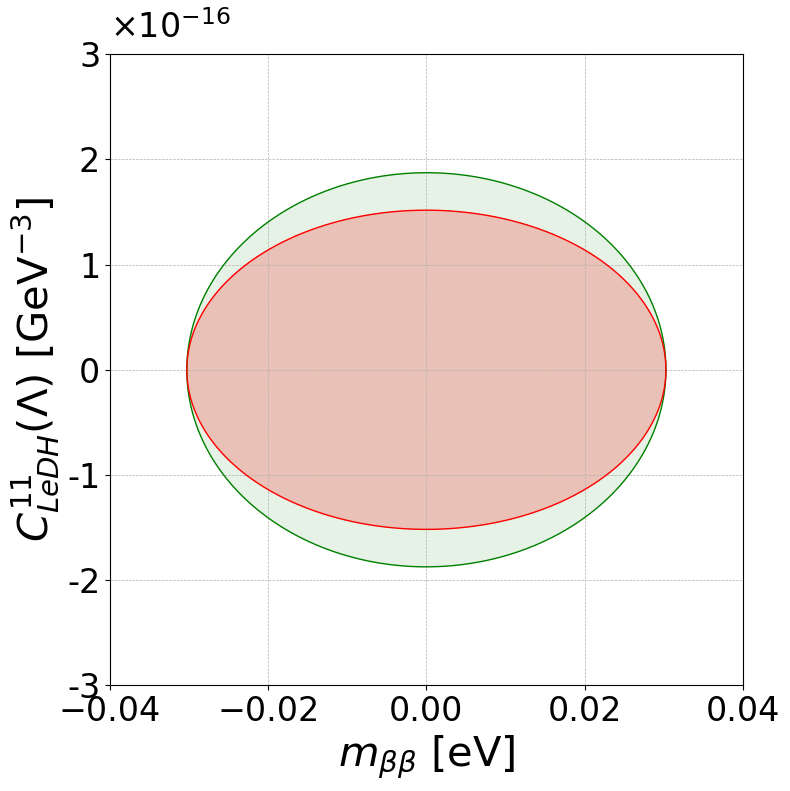

In [4]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"LeDH_11": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-3e-16, 3e-16, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.2)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)



ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{LeDH}^{11}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e16))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-16}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# ax.text(0.97, 0.07, r'$\Lambda = 10$ TeV', transform=ax.transAxes, fontsize=28, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_LeDH.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()

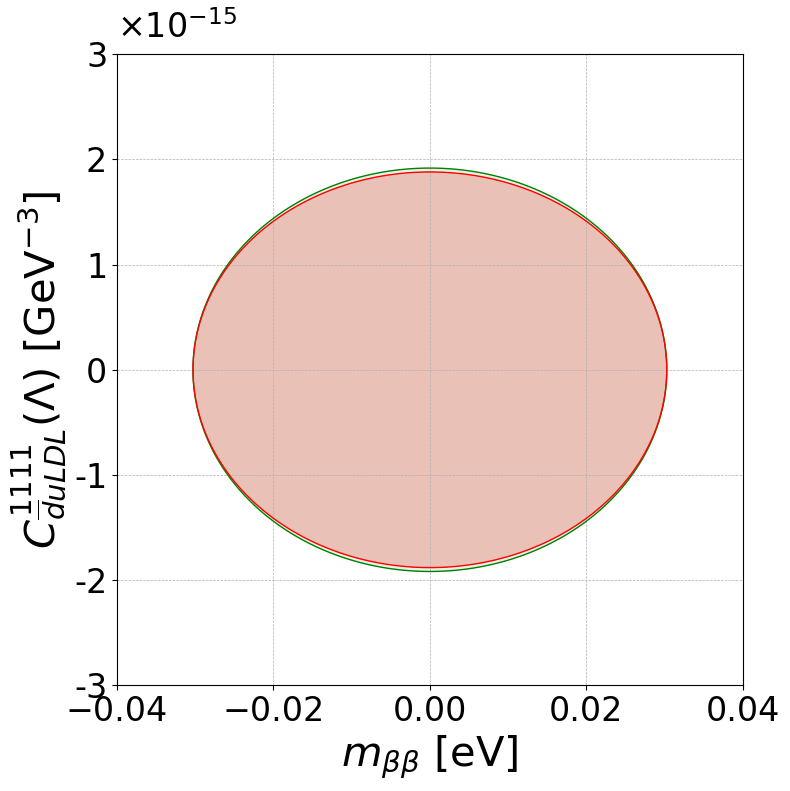

In [5]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"duLDL_1111": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-3e-15, 3e-15, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.2)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)



ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{\overline{d}uLDL}^{1111}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e15))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-15}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_duLDL.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()


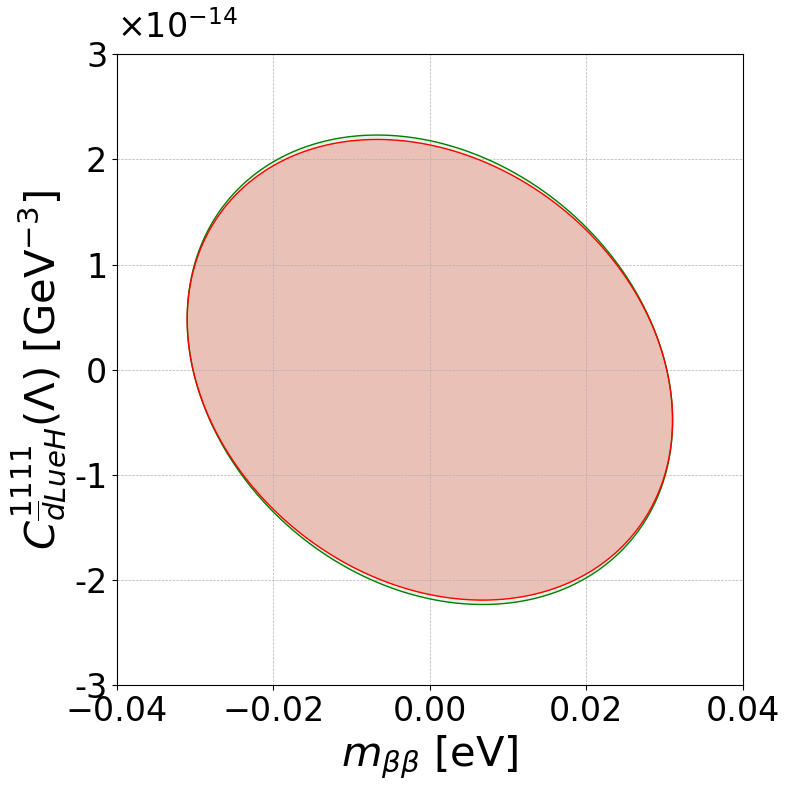

In [6]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"dLueH_1111": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-3e-14, 3e-14, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.2)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)



ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{\overline{d}LueH}^{1111}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e14))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-14}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_dLueH.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()

plt.show()

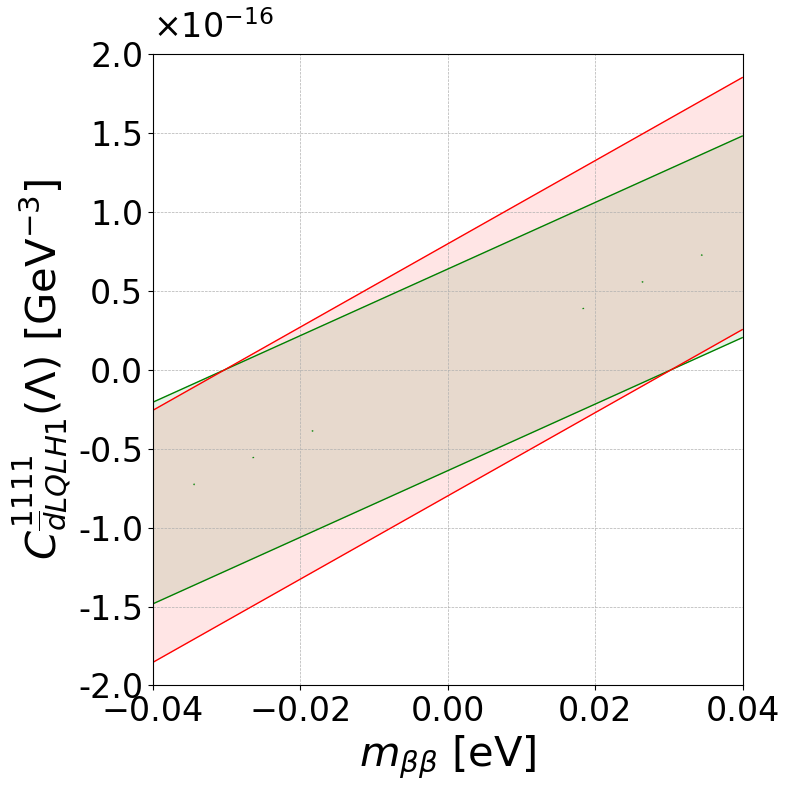

In [7]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"dLQLH1_1111": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-2e-16, 2e-16, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.1)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)



ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{\overline{d}LQLH1}^{1111}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 1e16))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-16}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_dLQLH1.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()

plt.show()

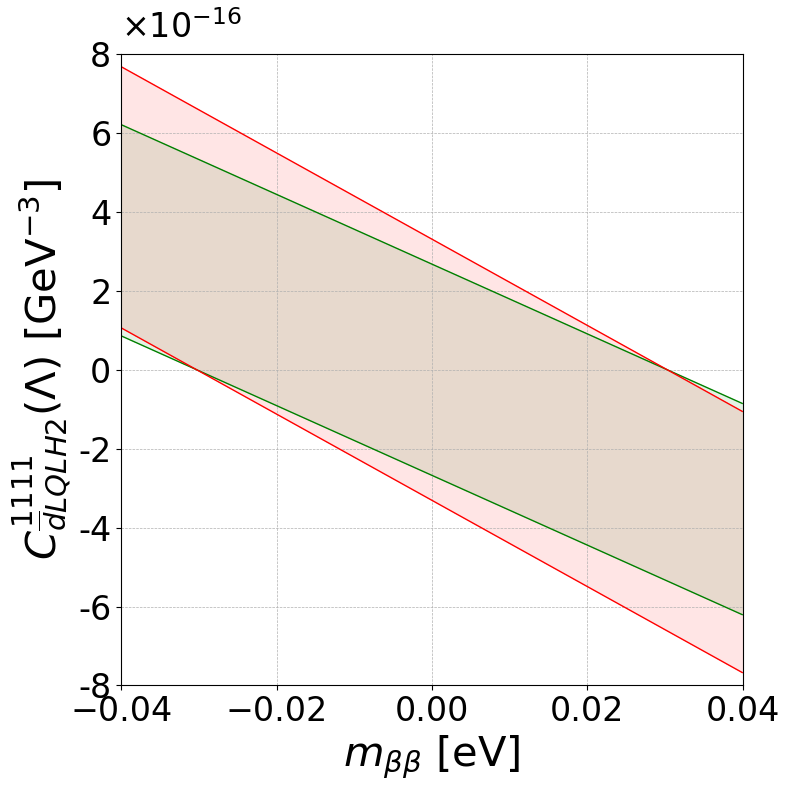

In [8]:
scale_in = 10e3
scale_out = 80
method = 'integrate'
C_ref = 1e-15
C_in1 = {"dLQLH2_1111": C_ref}

def compute_half_life_region1(mbb_vals, C7_vals, scale_in):
    C_out1 = solve_rge(scale_in, scale_out, C_in1, method=method, basis="down")
    C_out_0vbb_ref1 = extract_0vbb_operators_downbasis(C_out1)
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {key: val * (x / C_ref) for key, val in C_out_0vbb_ref1.items()}
    C_out_0vbb_scaled2 = {"LH(7)": -(mbb*2)/(246**4)*(10**(-9))}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-0.04, 0.04, 3000)
C7_vals = np.linspace(-8e-16, 8e-16, 3000)

mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=10e3)
mbb_grid_2, C7_grid_2, half_life_grid_2 = compute_half_life_region1(mbb_vals, C7_vals, scale_in=80)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.1)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)


contour2 = ax.contourf(mbb_grid_2, C7_grid_2, half_life_grid_2, 
                       levels=[2.3e26, np.max(half_life_grid_2)], 
                       colors=['red'], alpha=0.1)
ax.contour(mbb_grid_2, C7_grid_2, half_life_grid_2, 
           levels=[2.3e26], colors=['red'], 
           linestyles='-', linewidths=1)



ax.set_xlabel(r"$m_{\beta\beta}$ [eV]", fontsize=30)
ax.set_ylabel(r"$C_{\overline{d}LQLH2}^{1111}(\Lambda) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e16))
ax.yaxis.set_major_formatter(formatter) 

ax.text(0.0, 1.07, r'$\times 10^{-16}$', transform=ax.transAxes, fontsize=24, verticalalignment='top', horizontalalignment='left', color='black')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

import os
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, "mbb_dLQLH2.pdf")
plt.savefig(output_file_path, dpi=300)
plt.show()

plt.show()

#### Cross check with $\nu \text{DoBe}$---agree with our results
#### In $\nu \text{DoBe}$, mbb cannot be drawed with the SMEFT operator together because $\nu \text{DoBe}$ only allow the 2D plot of operators in same EFT  
#### mbb is LEFT operator and LH(5) is SMEFT operator, so that the other SMEFT operators can only be drawed with LH(5) or LH(7) together in $\nu \text{DoBe}$
#### The automated command nudobe.plots.contours in $\nu \text{DoBe}$ could generate the 2D plot of the constrains on $C_{LH}^{(5)}(\Lambda_{\text{EW}})-C_7^i(\Lambda_{\text{EW}})$ directly
#### The red regions in above plots should be very close to the blue regions in the following plots if we make the substitution:
#### $C_{dLQLH1}^{1111}\rightarrow C_{dLQLH1}^{(7)}$  $\quad$   $C_{dLQLH2}^{1111}\rightarrow C_{dLQLH2}^{(7)}$   
#### $C_{dLueH}^{1111}\rightarrow 1/2 C_{LeudH}^{(7)}$   $\quad$   $C_{LeDH}^{11}\rightarrow C_{LHDe}^{(7)}$  $\quad$    $C_{duLDL}^{1111}\rightarrow C_{LLduD1}^{(7)}$

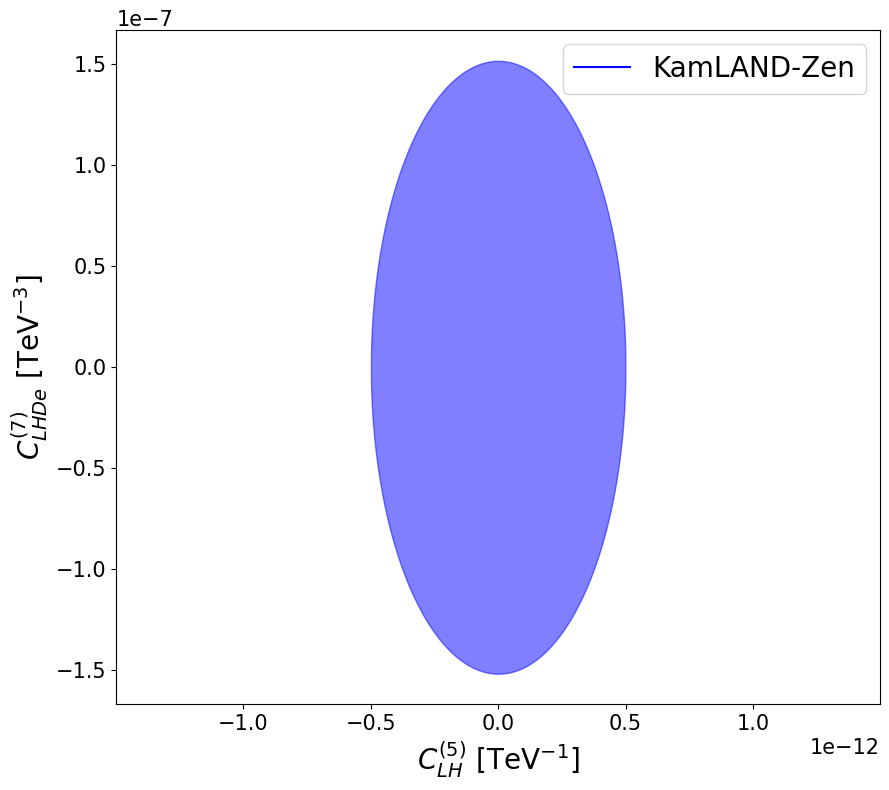

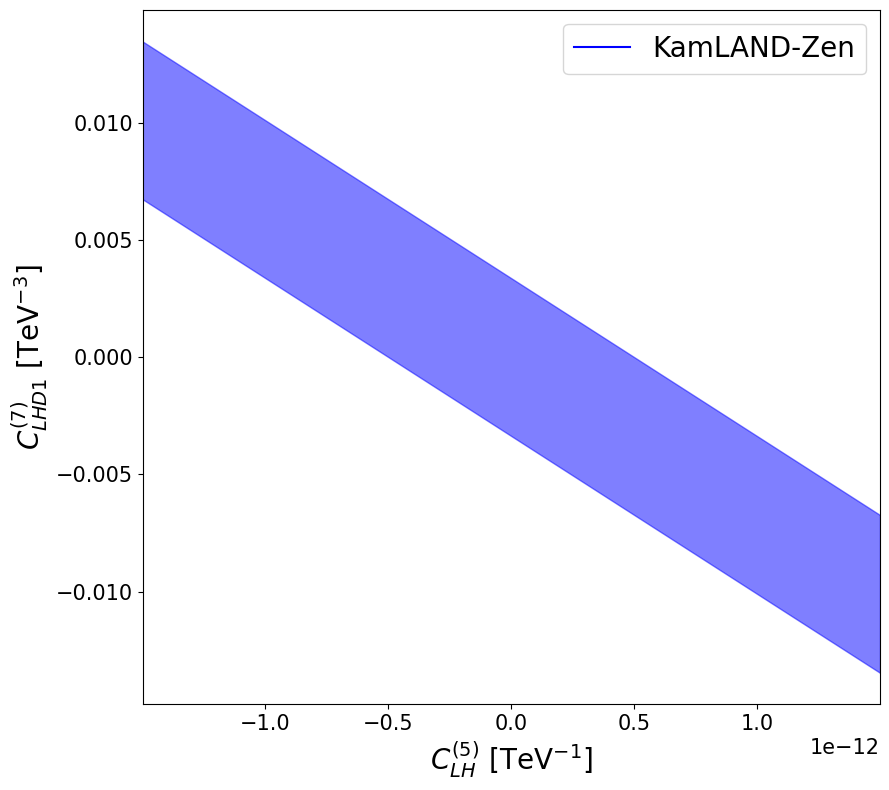

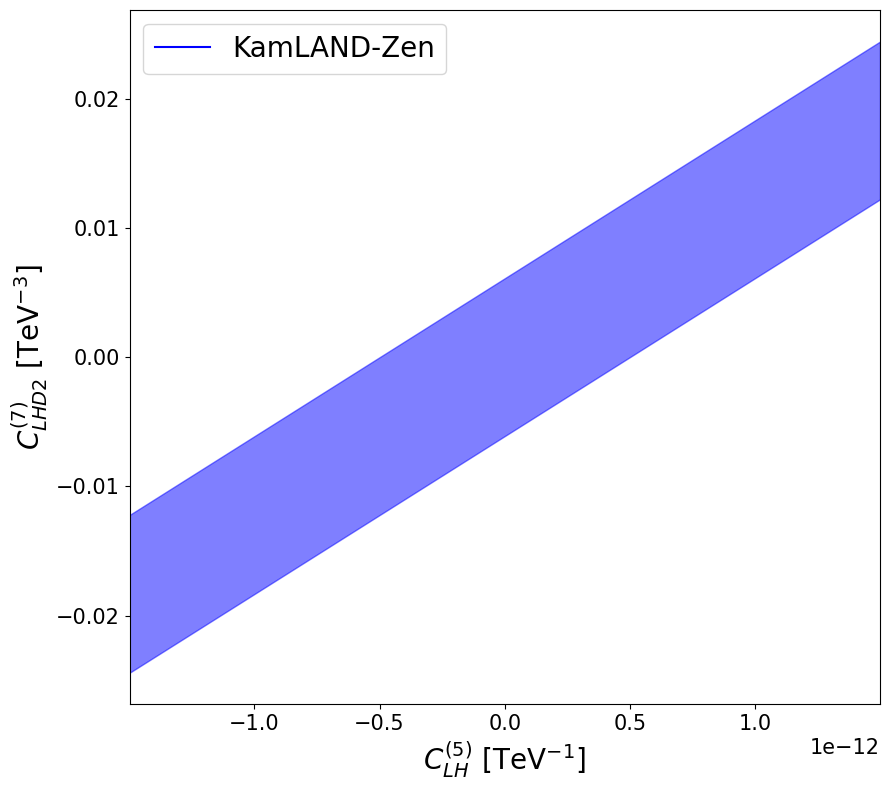

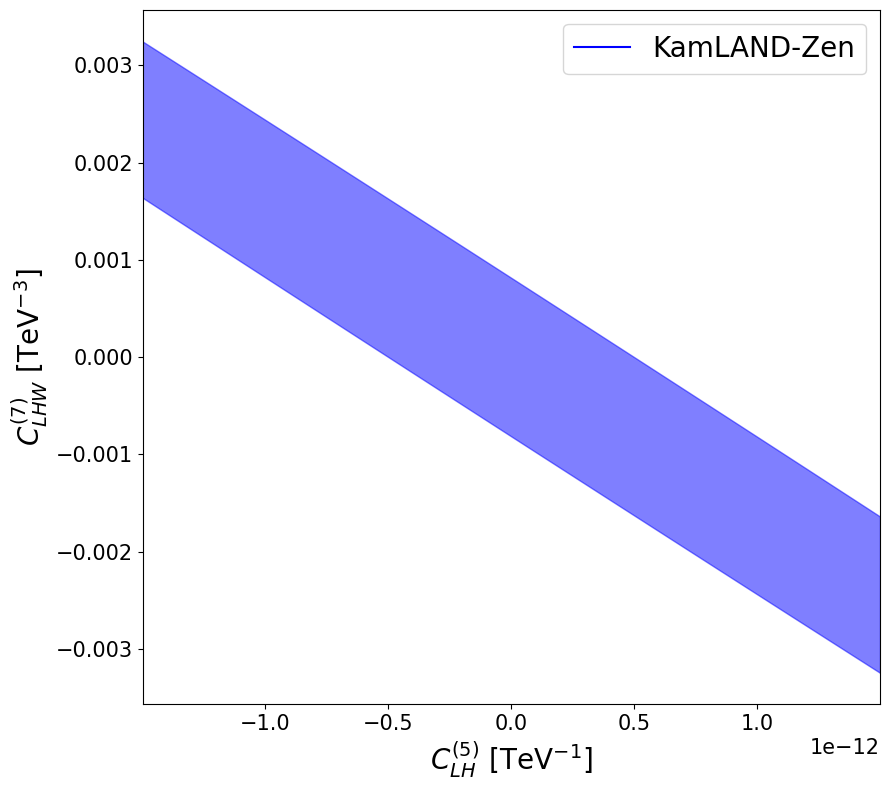

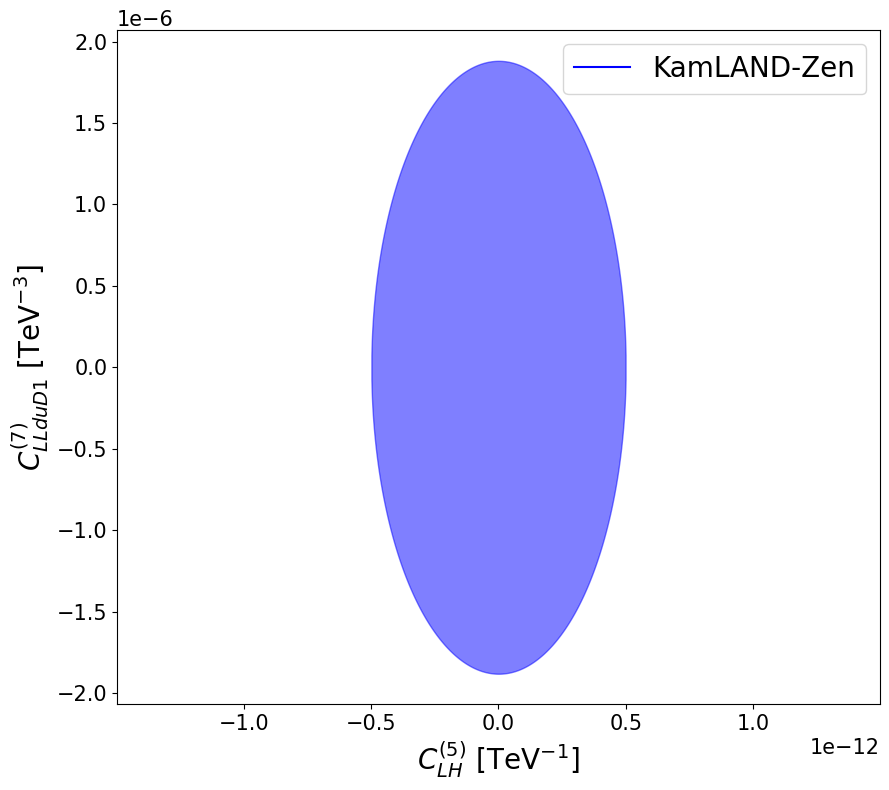

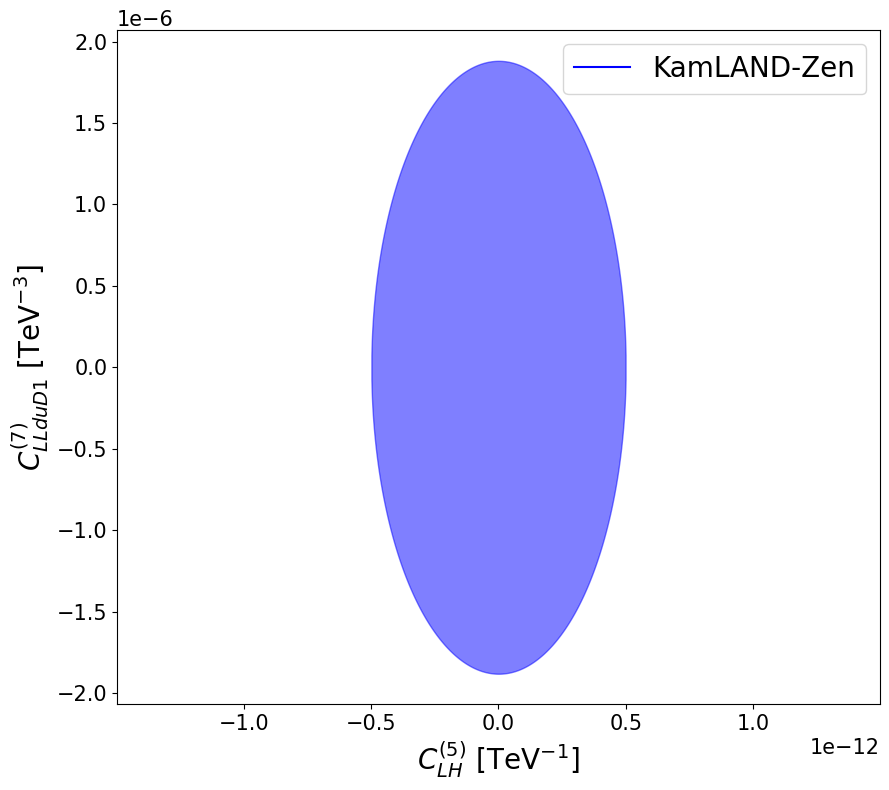

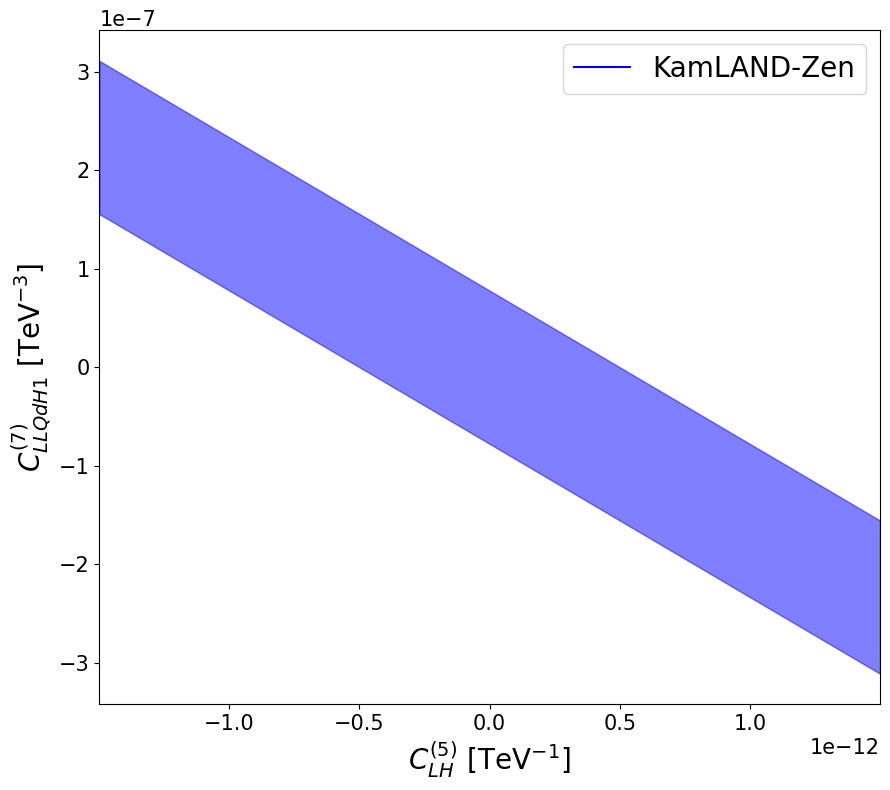

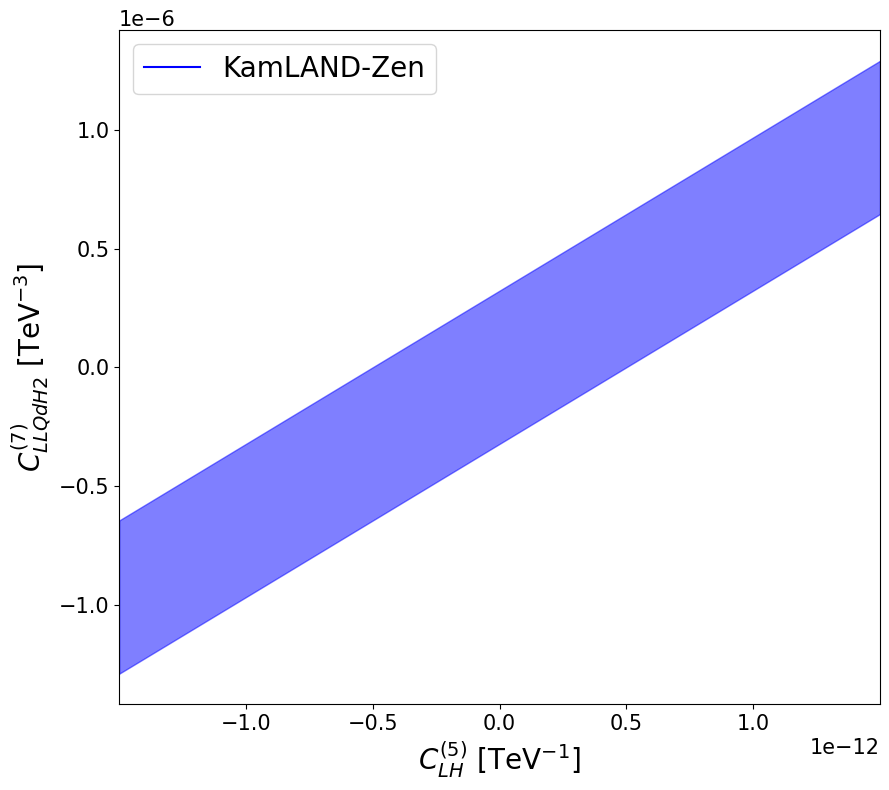

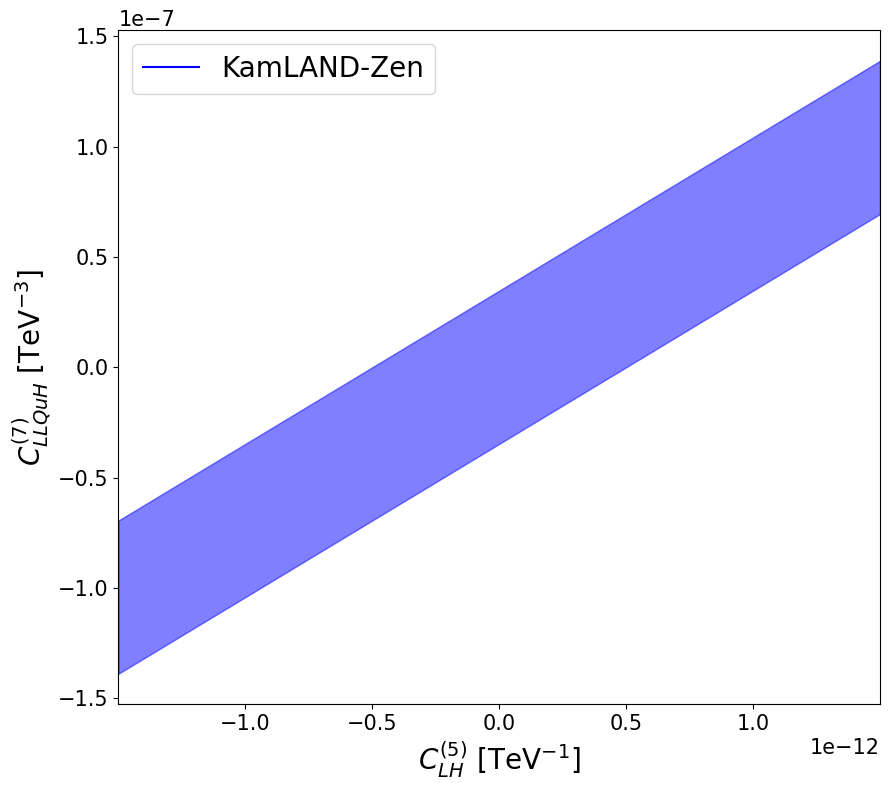

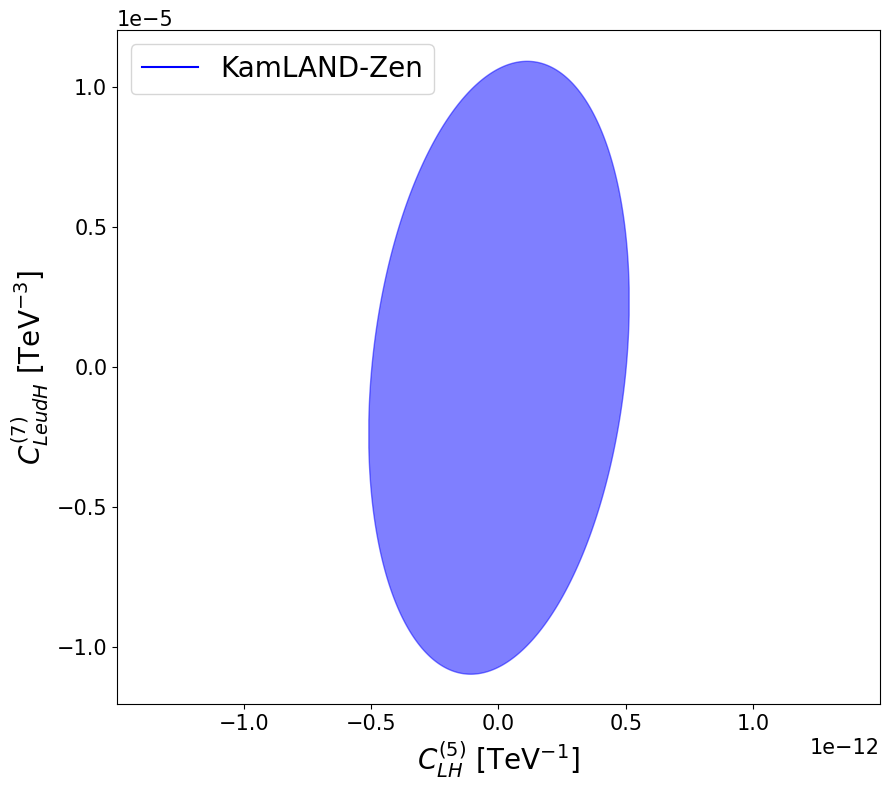

In [9]:
B=nudobe.plots.contours("LH(5)", "LHDe(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
A=nudobe.plots.contours("LH(5)", "LHD1(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )

#Plot contour limits from one experiment
B=nudobe.plots.contours("LH(5)", "LHD2(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LHW(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LLduD1(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LLduD1(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LLQdH1(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LLQdH2(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LLQuH(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )
B=nudobe.plots.contours("LH(5)", "LeudH(7)", 
                      limits = {"KamLAND-Zen" : {"half-life" : 2.3e+26,
                                                 "isotope" : "136Xe",
                                                 "color" : "b",
                                                 "label" :"KamLAND-Zen"}
                             },
                      PSF_scheme = "A"
                     )


## Test our analytical expression for half-life of $0\nu\beta\beta$ decay in function half_life_136Xe by comparing with nudobe. 
### They are agreed as the following green regions generated by function half_life_136Xe definded in 0vbb.py are the same as the blue regions above, which is generated by $\nu \text{DoBe}$

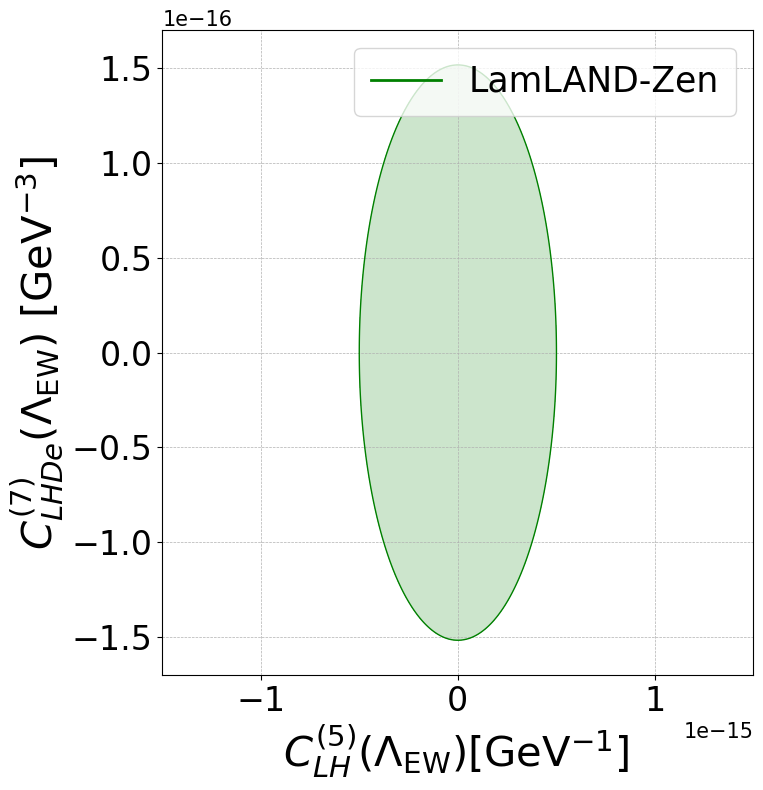

In [10]:
def compute_half_life_region1(mbb_vals, C7_vals):
 
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LHDe(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-1.7e-16, 1.7e-16, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LHDe}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

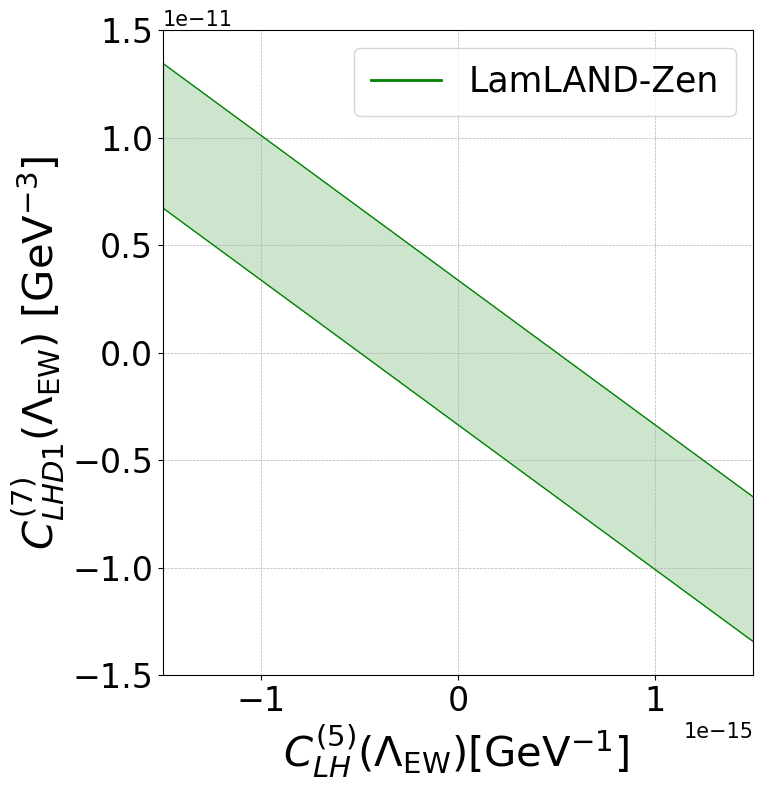

In [11]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LHD1(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-1.5e-11, 1.5e-11, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LHD1}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

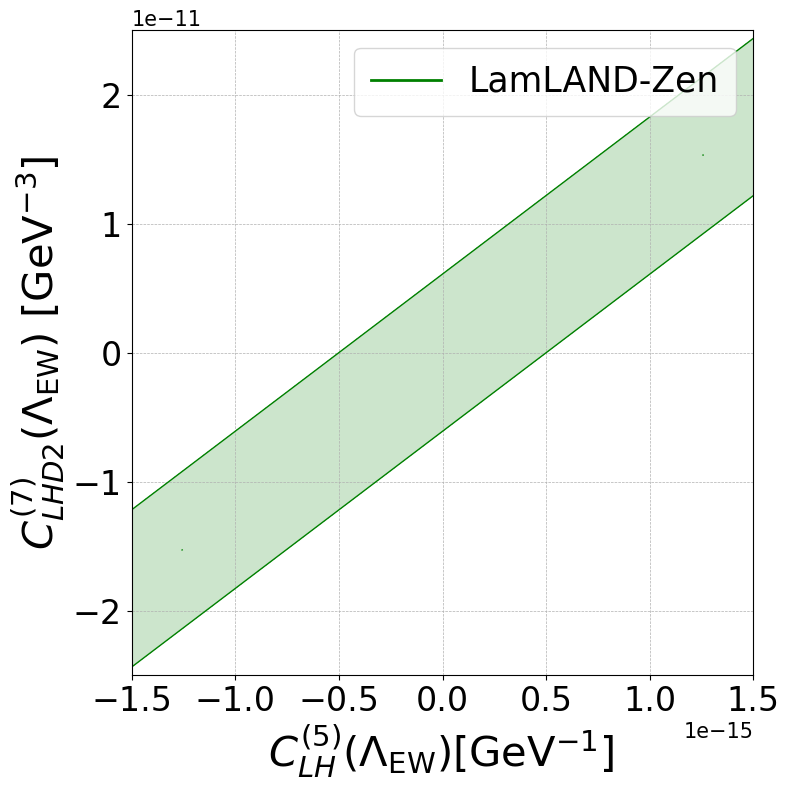

In [12]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LHD2(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-2.5e-11, 2.5e-11, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LHD2}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

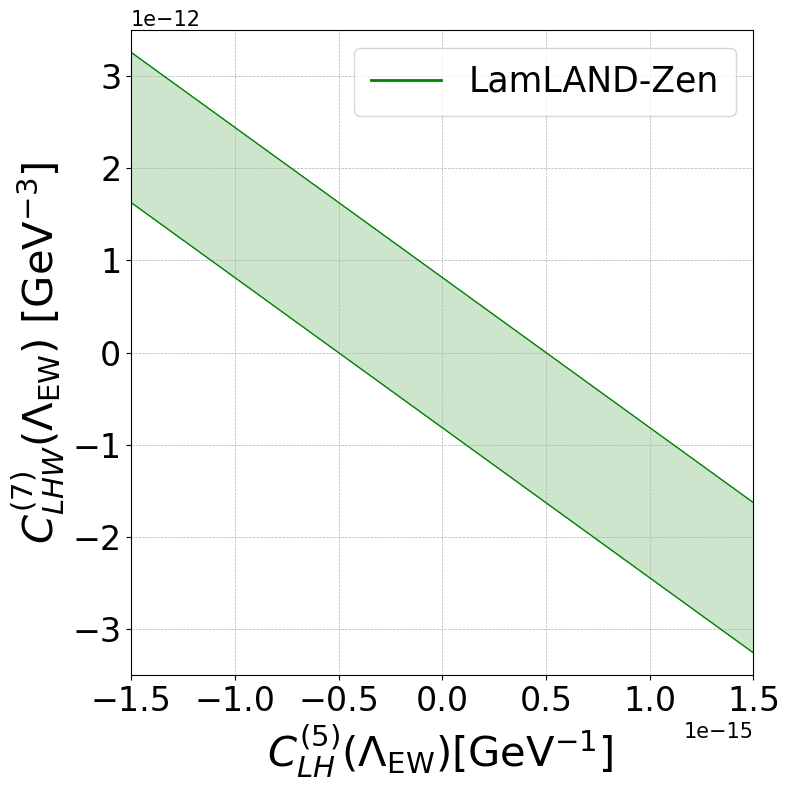

In [13]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LHW(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-3.5e-12, 3.5e-12, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LHW}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

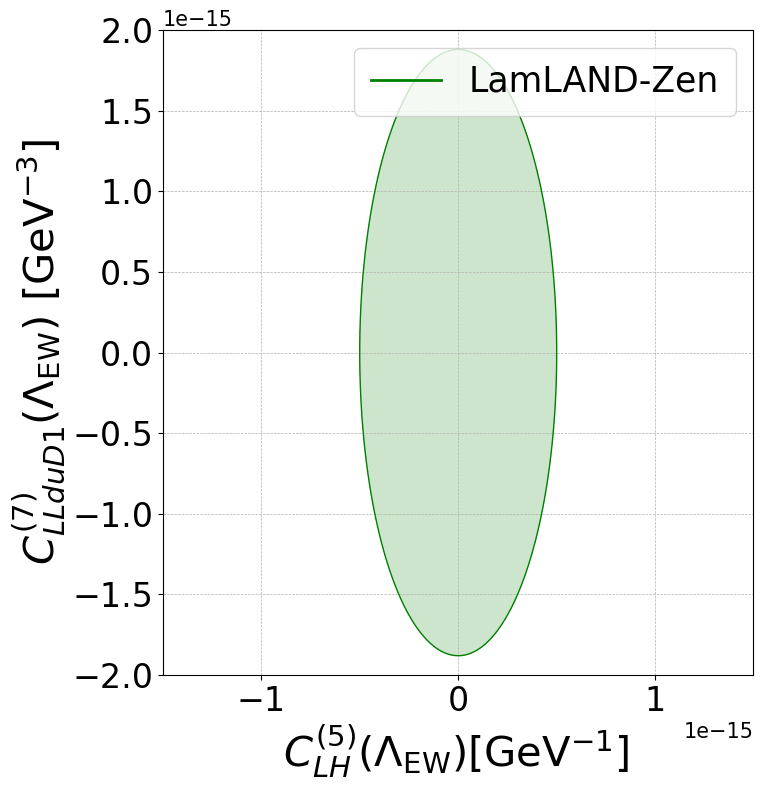

In [14]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LLduD1(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-2e-15, 2e-15, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LLduD1}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

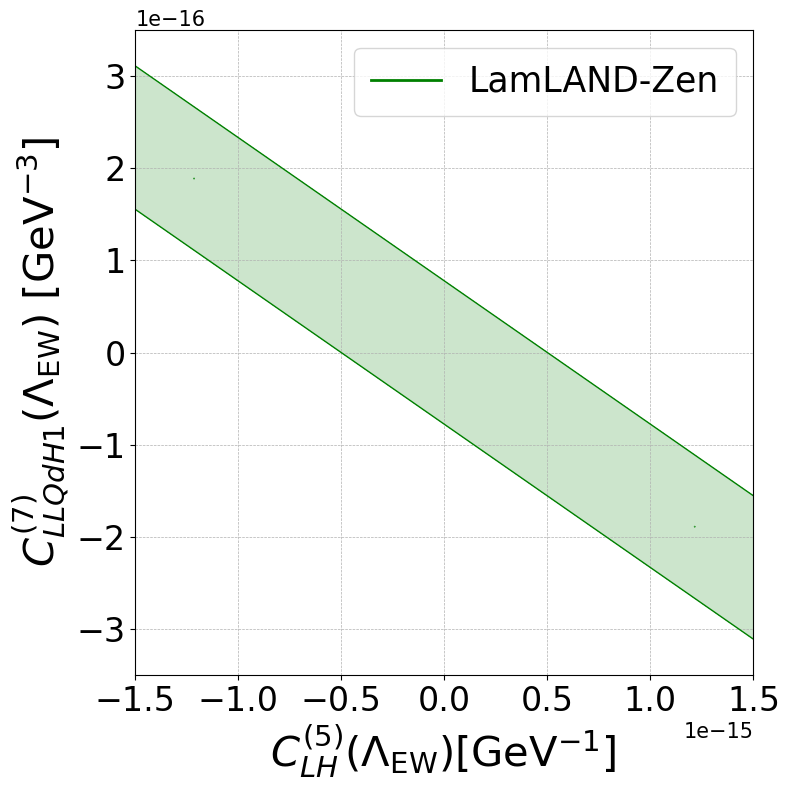

In [15]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D



def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LLQdH1(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-3.5e-16, 3.5e-16, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LLQdH1}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

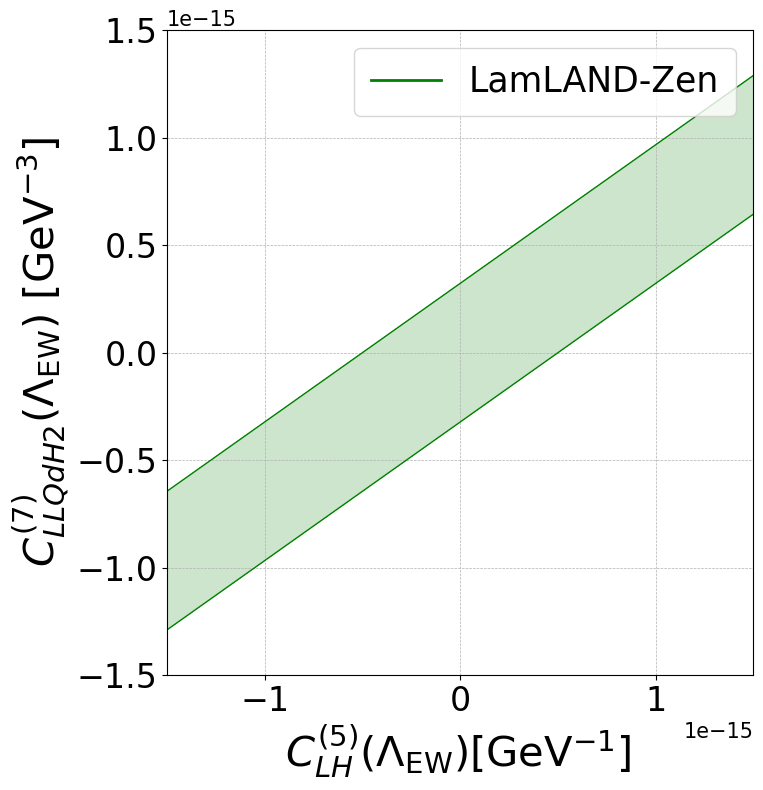

In [16]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LLQdH2(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LLQdH2}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

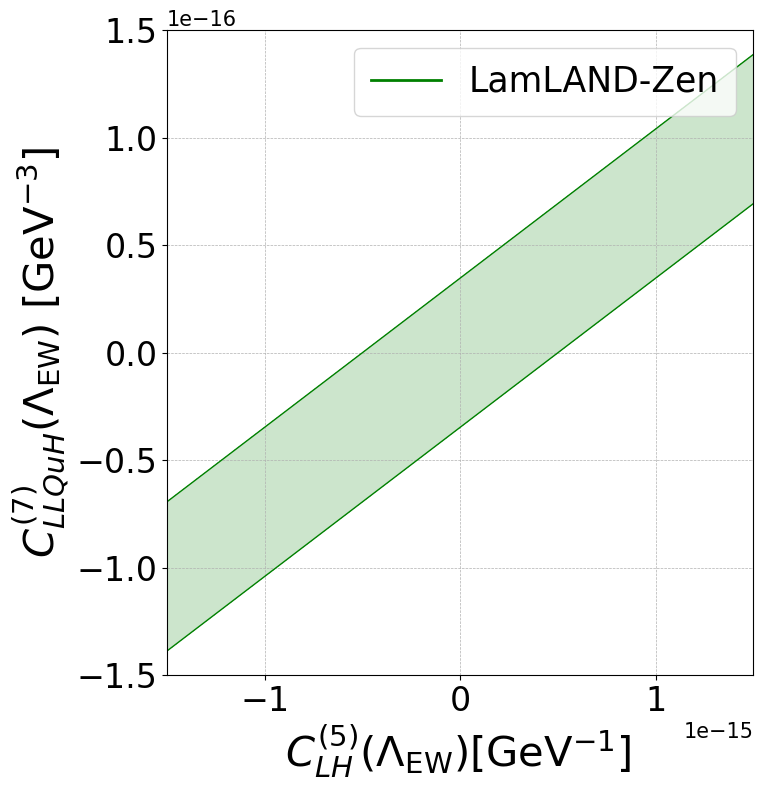

In [17]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LLQuH(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-1.5e-16, 1.5e-16, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LLQuH}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()


ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

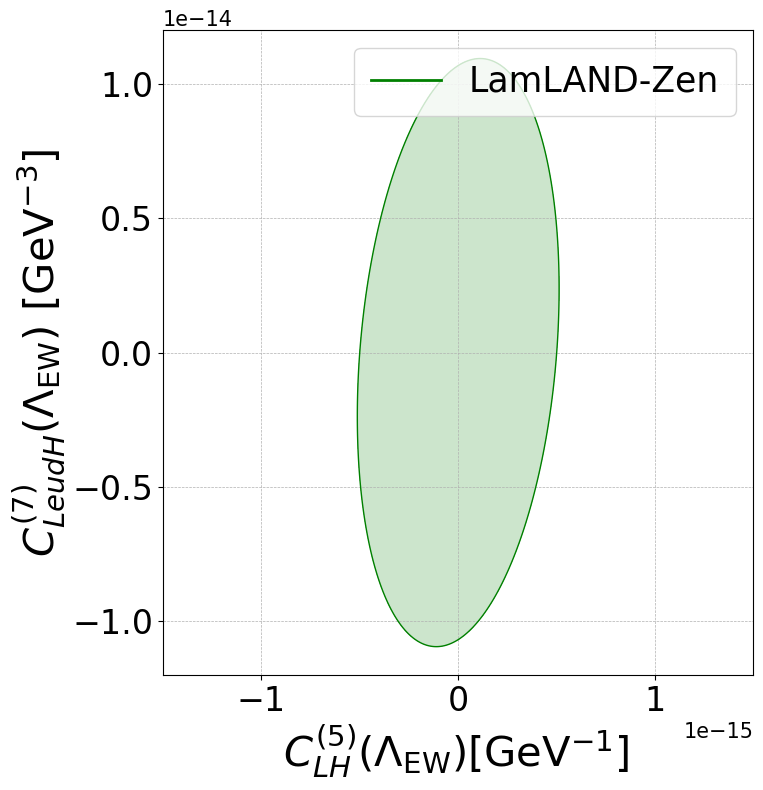

In [18]:
from ovbb import half_life_136Xe
from sympy import symbols, simplify
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




def compute_half_life_region1(mbb_vals, C7_vals):
    
    
    x = symbols('C7')
    mbb = symbols('mbb')
    C_out_0vbb_scaled1 = {"LeudH(7)":x}
    C_out_0vbb_scaled2 = {"LH(5)": mbb}
    C_out_0vbb_summed = {}
    all_keys = set(C_out_0vbb_scaled1.keys()).union(C_out_0vbb_scaled2.keys())
    for key in all_keys:
        if key in C_out_0vbb_scaled1 and key in C_out_0vbb_scaled2:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]
        elif key in C_out_0vbb_scaled1:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled1[key]
        else:
            C_out_0vbb_summed[key] = C_out_0vbb_scaled2[key]

    T_inv_expr = half_life_136Xe(C_out_0vbb_summed)
    T_half_simplified = simplify(T_inv_expr)
    half_life_expr = T_half_simplified
    half_life_func = lambdify((mbb, x), half_life_expr, modules=['numpy', 'sympy'])

    mbb_grid, C7_grid = np.meshgrid(mbb_vals, C7_vals)
    half_life_grid = half_life_func(mbb_grid, C7_grid)
    return mbb_grid, C7_grid, half_life_grid


mbb_vals = np.linspace(-1.5e-15, 1.5e-15, 3000)
C7_vals = np.linspace(-1.2e-14, 1.2e-14, 3000)


mbb_grid_1, C7_grid_1, half_life_grid_1 = compute_half_life_region1(mbb_vals, C7_vals)


fig, ax = plt.subplots(figsize=(8, 8))


contour1 = ax.contourf(mbb_grid_1, C7_grid_1, half_life_grid_1, 
                       levels=[2.3e26, np.max(half_life_grid_1)], 
                       colors=['green'], alpha=0.2)
ax.contour(mbb_grid_1, C7_grid_1, half_life_grid_1, 
           levels=[2.3e26], colors=['green'], 
           linestyles='-', linewidths=1)





legend_elements = [
        Line2D([0], [0], color='green', lw=2, linestyle='-', label='LamLAND-Zen'),
    ]

ax.legend(handles=legend_elements, loc='upper right', fontsize=25, frameon=True, borderpad=0.5)


ax.set_xlabel(r"$C_{LH}^{(5)}(\Lambda_{\text{EW}})[\text{GeV}^{-1}]$ ", fontsize=30)
ax.set_ylabel(r"$C_{LeudH}^{(7)}(\Lambda_{\text{EW}}) \ [\text{GeV}^{-3}]$", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)



plt.tight_layout()

# plt.savefig("combined_contour_plot.png", dpi=300)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()